<a href="https://colab.research.google.com/github/JoaoGranja/Semantic_Segmentation/blob/master/semantic_segmentation_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
is_colab = True


# **Colab Preparation** 
Before handling the project, we need to install tensorflow/keras and pip packages. I also share my google drive to simplify the connection with my google drive account.



In [2]:
if is_colab:
    #Package Installation and share Google Drive
    !pip install --upgrade pip
    #!pip install --upgrade keras
    !pip install keras-resnet
    !pip install tensorflow==2.4.0
    !pip install tensorflow-gpu==2.4.0
    !pip install tensorflow_addons
    !pip install keras==2.4

    !pip install keras-segmentation

    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # **Configuration and imports**

The first thing I do is to import all modules we need for this project. I also use some configuration parameters to provide more flexibility to the tranining process

In this project I will be making use of the Keras library for creating our model and training it. I will also use Matplotlib for visualizing our dataset to gain a better understanding of the images we are going to be handling.



In [3]:
# Generic Imports
import time
import gc
import logging, os
import sys
import random
import warnings
import pickle
from math import ceil
from tqdm import tqdm
from itertools import chain

# data processing and visualization library
import numpy as np
import pandas as pd
#import seaborn as sns
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2 

# tensorflow and keras for DL model
import tensorflow as tf
import tensorflow_datasets as tfds
#logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow.keras.layers.experimental import preprocessing

if is_colab:
    from google.colab import files
    sys.path.append('/content/drive/MyDrive/colab/Semantic_Segmentation')
    os.chdir('/content/drive/MyDrive/colab/Semantic_Segmentation')
    
#------------------------------  Set some configuration parameters -----------------------------------#
args = {}
args['seed'] = 42
args['save_dataset'] = False

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# **Dataset**

In this semantic segmentation project, the oxford_iiit_pet dataset will be used. It will be downloaded from the tensorflow dataset API, preprocessed and then saved the dataset on google drive for future use.

In [4]:
def normalize(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  label -= 1
  return image, tf.cast(label, tf.uint8)

def load_image(datapoint, input_shape=224):
  input_image = tf.image.resize(datapoint['image'], (input_shape, input_shape))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (input_shape, input_shape))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same randomn changes.
    self.augment_images = tf.keras.Sequential([preprocessing.RandomFlip(mode="horizontal", seed=seed),
    ])
    self.augment_labels = tf.keras.Sequential([preprocessing.RandomFlip(mode="horizontal", seed=seed),
    ])

  def call(self, inputs, labels):
    inputs = self.augment_images(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [5]:
if args['save_dataset']:
  #------------------------------  Load dataset using tf.dataset API -----------------------------------#
  dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
  train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  val_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

  BATCH_SIZE = 64
  BUFFER_SIZE = 1000
  INPUT_SHAPE = [224,224,3]
  OUTPUT_CLASSES = 3
  STEPS_PER_EPOCH = info.splits['train'].num_examples // BATCH_SIZE
  VAL_SUBSPLITS = 5
  VALIDATION_STEPS = info.splits['test'].num_examples //BATCH_SIZE//VAL_SUBSPLITS


  # Create Train and validation Batches
  train_batches = (
      train_images
      .cache()                                 # The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)                       # Combines consecutive elements of this dataset into batches.
      .repeat()                                # Repeats this dataset so each original value is seen count times.
      .map(Augment())
      .prefetch(buffer_size=tf.data.AUTOTUNE)) # This allows later elements to be prepared while the current element is being processed.

  val_batches = val_images.batch(BATCH_SIZE)

In [6]:
if args['save_dataset']:
  #------------------------------ Plot random mask -----------------------------------#
  for image, mask in val_images.as_numpy_iterator():
      image_name = "dataset/image_1.png"
      label_name = "dataset/label_1.png"
      #image_ = tf.keras.preprocessing.image.array_to_img(image)
      #mask_ = tf.keras.preprocessing.image.array_to_img(mask)
      cv2.imwrite(image_name, image)
      cv2.imwrite(label_name, mask)
      print(image.shape)
      print(np.unique(mask))
      print(mask.shape)
      print(mask.dtype)
      mask_ = cv2.imread(label_name)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(mask_))
      break;


In [7]:
if args['save_dataset']:
  i = 0
  for image, mask in train_images.as_numpy_iterator():
    i = i + 1
    print(i)
    image_name = "dataset/oxford_train/images/image_" + str(i) + '.png'
    label_name = "dataset/oxford_train/labels/image_" + str(i) + '.png'
    cv2.imwrite(image_name, image)
    cv2.imwrite(label_name, mask)

[0 1 2]
(224, 224, 3)
(224, 224, 3)
uint8


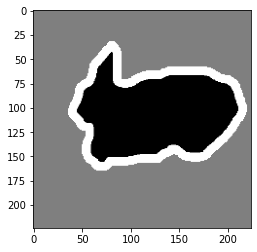

In [8]:
#Plot some mask image to verify it was correctled saved
image_name = "dataset/oxford_train/images/image_1.png"
label_name = "dataset/oxford_train/labels/image_1.png"
image_ = cv2.imread(image_name)
mask_ = cv2.imread(label_name)
print(np.unique(mask_))
print(mask_.shape)
print(image_.shape)
print(mask_.dtype)
plt.imshow(tf.keras.preprocessing.image.array_to_img(mask_))

[ 0  1  2  3  4  5  6  7  8  9 11]
(360, 480, 3)
(360, 480, 3)
uint8


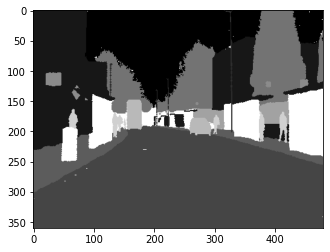

In [9]:
#Dataset1
image_name = "dataset1/images_prepped_train/0016E5_08640.png"
label_name = "dataset1/annotations_prepped_train/0016E5_08640.png"
image_ = cv2.imread(image_name)
mask_ = cv2.imread(label_name)
print(np.unique(mask_))
print(mask_.shape)
print(image_.shape)
print(mask_.dtype)
plt.imshow(tf.keras.preprocessing.image.array_to_img(mask_))

In [10]:
if args['save_dataset']:
  i = 0
  for image, mask in val_images.as_numpy_iterator():
    i = i + 1
    image_name = "dataset/oxford_test/images/image_" + str(i) + '.png'
    label_name = "dataset/oxford_test/labels/image_" + str(i) + '.png'
    cv2.imwrite(image_name, image)
    cv2.imwrite(label_name, mask)

# **Model and Training**

In this case, I will import the mobilenet_unet model from the  [image-segmentation-keras](https://github.com/divamgupta/image-segmentation-keras) repository and train it using the oxford_iiit_pet dataset.

In [11]:
from keras_segmentation.models.unet import mobilenet_unet

#model = mobilenet_unet(n_classes=51 ,  input_height=416, input_width=608  ) 
model = mobilenet_unet(n_classes=3 ,  input_height=224, input_width=224  )

model.train(
    train_images =  "dataset/oxford_train/images/",
    train_annotations = "dataset/oxford_train/labels/",
    verify_dataset = False,
    checkpoints_path = "/tmp/mobile_unet_1" , epochs=10
)

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
512/512 [==============================] - 53s 92ms/step - loss: 1.2362 - accuracy: 0.4704
saved  /tmp/mobile_unet_1.0
Epoch 2/10
512/512 [==============================] - 475s 929ms/step - loss: 0.8962 - accuracy: 0.6458
saved  /tmp/mobile_unet_1.1
Epoch 3/10
512/512 [==============================] - 660s 1s/step - loss: 0.8151 - accuracy: 0.6882
saved  /tmp/mobile_unet_1.2
Epoch 4/10
512/512 [==============================] - 409s 798ms/step - loss: 0.7792 - accuracy: 0.7062
saved  /tmp/mobile_unet_1.3
Epoch 5/10
512/512 [==============================] - 47s 92ms/step - loss: 0.7481 - accuracy: 0.7223
saved  /tmp/mobile_unet_1.4
Epoch 6/10
512/512 [==============================] - 47s 93ms/step - loss: 0.7278 - accuracy: 0.7295
saved  /tmp/mobile_unet_1.5
Epoch 7/10
512/512 [==============================] - 47s 92ms/step - loss: 0.6981 - accuracy: 0.7437
saved  /tmp/mobile_unet_1.6
Epoch 8/10
512/512 [==============================] - 47s 92ms/step - loss: 0.7003 - ac

# **Evaluation**

Now it is time to evaluate the trained model on the testing dataset

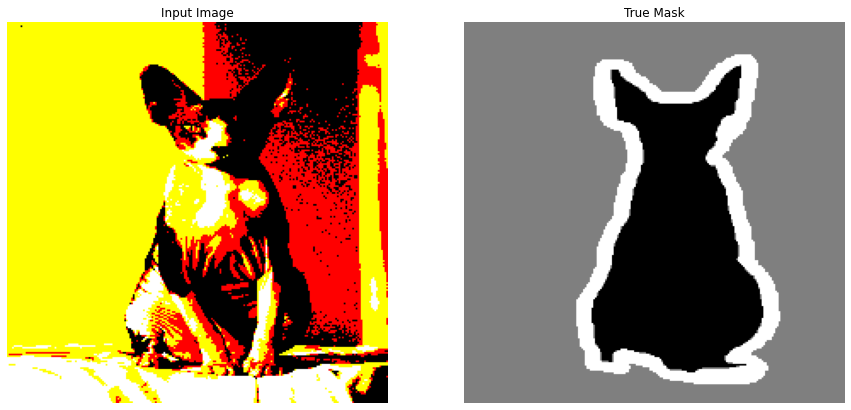

In [12]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    #plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()



def show_predictions(model):
  image = cv2.imread("dataset/oxford_train/images/image_5.png")
  label = cv2.imread("dataset/oxford_train/labels/image_5.png")
  display_list = [image, label]
  display(display_list)


#Try out the model on an image from the test data:
show_predictions(model)

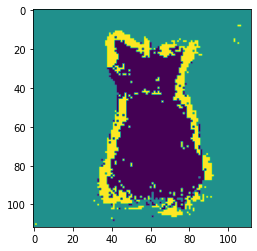

In [13]:
out = model.predict_segmentation(
    inp="dataset/oxford_train/images/image_5.png",
    out_fname="/tmp/out.png"
)
plt.imshow(out)

In [14]:
# evaluating the model 
print(model.evaluate_segmentation( inp_images_dir="dataset/oxford_test/images/"  , annotations_dir="dataset/oxford_test/labels" ) )

3669it [55:31,  1.10it/s]

{'frequency_weighted_IU': 0.6446613449340416, 'mean_IU': 0.5241073267816848, 'class_wise_IU': array([0.59268268, 0.7529659 , 0.22667341])}
